#Perceptron
##Training Data
* Feature matrix $X_{(n,m+1)}$ includes dummy feature $x_0$ that is set to 1.
* Label vector is $y_{(n,1)}$
Perceptron can solve only binary classification problems.

##Model
$$ h_w: y = sign(W^T 𝞥(x))  
           = sign(z)  $$  
where w is a weight vector in $R^{(m+1)}$

$$ sign(z) = \{^{+1  if z>=0} _ {-1 otherwise}   $$

##Loss function
$$ J(W) = 𝚺_{i=1}^n e^{(i)} = 𝚺_{i=1}^n max(-h_w(x^{(i)})y^{(i)},0)
$$

##Optimisation Procedure
1. Initialize $w^{(0)} = 0$
2. for each training example, $(x^{(i)},y^{(i)})$
  * $ŷ^{(i)} = sign(W^T X^{(i)})$ [calculate the output value]
  * $w^{(t+1)}:= w^{(t)} + α (y^{(i)} - ŷ^{(i)}) 𝜱(X^{(i)})   $ [update the weights]

Linear Separable examples leads to convergence of the algorithm with zero training loss, else it oscillates.  
## Evaluation Metrics
* Confusion metrics
* Precision/Recall/F1

In [ ]:
# Import Libraries:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools
import seaborn as sns
import math
np.random.seed(111)

In [ ]:
def encode(labels):
  k = np.max(labels) + 1
  encoder = np.eye(k)
  return encoder[labels]

#encode([1,2,3,4])

In [ ]:
# @title [polynomial transformation]
def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x, degree)

def compute_new_feature(items):
  return functools.reduce(lambda x, y: x*y, items) 

def polynomial_transform(x, degree, logging=False):
  #convert feature to matrix
  if(x.ndim ==1):
    x = x[:,None]
  x_t = x.transpose()   # transpose of feature matrix
  features = [np.ones(len(x))] # populates 1's as first feature of each example
  if(logging):
    print('Input: ',x)

  for degree in range(1, degree + 1):
    for items in get_combinations(x_t,degree):  # generate combinations 
      features.append(compute_new_feature(items))  # combine features into new feature
      if(logging):
        print(items, ' : ', compute_new_feature(items))
  if(logging):
    print(np.asarray(features).transpose())
  return np.asarray(features).transpose()

In [ ]:
#Perceptron class
class Perceptron:
  ''' Implements perceptron class
      Class Variables:
        w: final weight vector
        w_all: all weight vector in training iterations
        errors_all: all errors in training iterations
  '''
  def __init__(self):
    self.w = None
  
  def predict(self, X):
    ''' Predicts label for input feature matrix X'''
    z = X @ self.w
    return np.where(z>=0, 1, -1)
  
  def loss(self, X, y):
    ''' Calculate loss due to current weight vector w and label vector y
      Arguments:
        X: feature matrix
        y: label vector
      Returns:
        None
    '''
    return np.sum(np.maximum(-1 * self.predict(X) * y, np.zeros(y.shape[0])))
  
  def train(self, X, y, epochs=10, lr=0.001):
    ''' Implements perceptron update rule
        Arguments:
        X: feature matrix
        y: label vector
        epochs: number of epochs
        lr: learning rate
      Returns:
        None
    '''
    self.w = np.zeros(X.shape[1])
    self.errors_all = []
    self.w_all = []

    for i in range(epochs):
      errors = 0
      for xi, target in zip(X, y):
        #print('error: ', errors)
        self.w += lr * (target - self.predict(xi)) * xi
        errors += (max(-1*self.predict(xi) * target, 0))
      
      self.errors_all.append(errors)
      # print('Loss : ',self.errors_all[-1])
      # print('w : ', self.w)
      self.w_all.append(self.w)
    
  #Commented for loss visualization. Uncomment in actual implementation
      if(self.loss(X, y) == 0):
        break      
    return self.w

In [ ]:
from numpy.core.multiarray import concatenate
#@title [create toy dataset]
def create_toy_data(add_outliers=False,add_class=False):
  x0 = np.random.normal(size=50).reshape(-1,2) - 2
  x1 = np.random.normal(size=50).reshape(-1,2) + 2
  if add_outliers:
    x_1 = np.random.normal(size=10).reshape(-1,2) + np.array([5., 10.])
    return np.concatenate([x0,x1,x_1]), np.concatenate([np.zeros(25),np.ones(30),]).astype(int)
  if add_class:
    x2 = np.random.normal(size=50).reshape(-1,2) + 2
    return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2+np.zeros(25)]).astype(int)
  return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.ones(25)]).astype(int)

In [ ]:
#@title [Data Preprocessing]

from sklearn.model_selection import train_test_split

def preprocess(add_class=False,add_outliers=False,degree=1):
  x, y = create_toy_data(add_outliers,add_class)
  #print(x[:5,:], y[:5])
  x_poly = polynomial_transform(x, degree=degree)
  x_train, x_test, y_train, y_test = train_test_split(x_poly, y)
  
  return x_train, x_test, y_train, y_test  

In [ ]:
#@title [model visualization]
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def visualize_model(x_train, labels, lsc_obj, degree=1):
  f = plt.figure(figsize=(8,8))
  
  #compute xlim and ylim
  x1_min = np.min(x_train[:,1])
  x1_max = np.max(x_train[:,1])
  x2_min = np.min(x_train[:,2])
  x2_max = np.max(x_train[:,2])

  x1_test, x2_test = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
  x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
  x_test_poly = polynomial_transform(x_test, degree=degree)
  y_test = lsc_obj.predict(x_test_poly)

  sns.scatterplot(data=x_train, x=x_train[:,-2], y=x_train[:,-1], hue=labels)
  plt.contourf(x1_test, x2_test, y_test.reshape(100,100),alpha=0.5, levels=np.linspace(0,1,3))
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.xlim(x1_min, x1_max)
  plt.ylim(x2_min, x2_max)
  plt.gca().set_aspect('equal',adjustable='box')
  plt.show()

In [ ]:
#@title [Linearly Separable binary classification]
#x1_train, x1_test, y1_train, y1_test, y1_train_trans, y1_test_trans = preprocess()
x1_train, x1_test, y1_train, y1_test = preprocess()
print('shape of training feature matrix', x1_train.shape)
print('shape of training label vector', y1_train.shape)

print('shape of test feature matrix', x1_test.shape)
print('shape of test label vector', y1_test.shape)

shape of training feature matrix (37, 3)
shape of training label vector (37,)
shape of test feature matrix (13, 3)
shape of test label vector (13,)


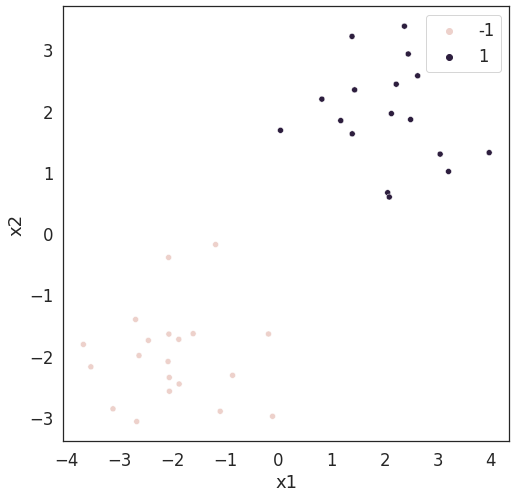

In [ ]:
#@title [Visualization of dataset]
sns.set_style("white")
f = plt.figure(figsize=(8,8))
sns.set_context("notebook",font_scale=1.5, rc={"lines.linewidth":2.5})
sns.scatterplot(data=x1_train, x=x1_train[:,-2], y= x1_train[:,-1],hue=y1_train)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

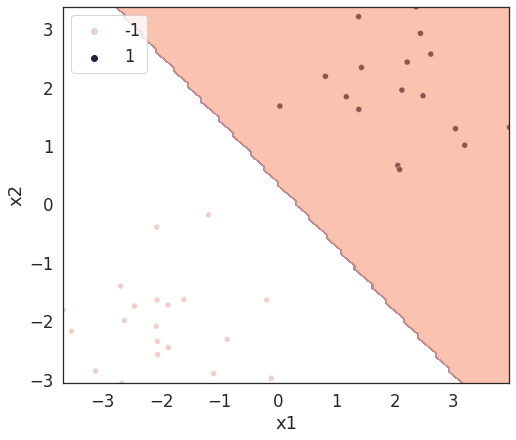

In [ ]:
perceptron_obj = Perceptron()
#print(x_train[:5,:], y_train[:5])
#print(x1_train[:5,:], y1_train[:5])
perceptron_obj.train(x1_train, y1_train,epochs=10, lr=0.01)
#print(perceptron_obj.w)
visualize_model(x1_train, y1_train, perceptron_obj, degree=1)

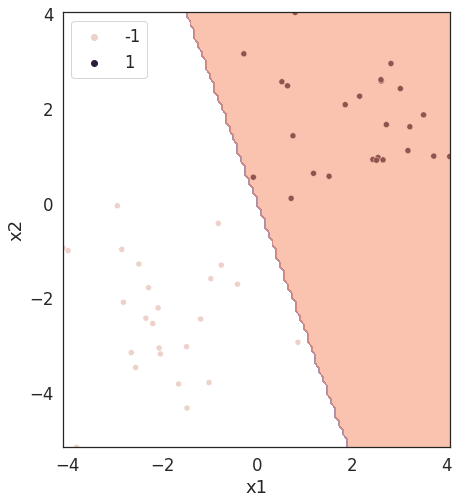

-0.3571712789206904 -1
Loss =  0


In [ ]:
#without train test split
XX, yy = create_toy_data()
x_poly = polynomial_transform(XX, degree=1)
p = Perceptron()
p.train(x_poly, yy,epochs=10, lr=0.01)
#print(perceptron_obj.w)
visualize_model(x_poly, yy, p, degree=1)
print(x_poly[0] @ p.w, yy[0])
print('Loss = ', max((-1*p.predict(x_poly[0]) * yy[0]), 0))